In [1]:
import os
import pandas as pd
from pathlib import Path
import numpy as np
import plotnine as gg

## Directories and Filepath

In [2]:
path = os.getcwd()
topdir="Repair Department Performance"
subdir='W46_2020'
figures = "figures"

folderpath = os.path.join(path, topdir, subdir)

outpath = os.path.join(folderpath, figures)


def create_figure_folder(outpath):
        
    if not os.path.exists(outpath):
        print ("figure directory is created")
        return os.makedirs(outpath)

    
    
output_dir = create_figure_folder(outpath)



csvpath = [os.path.join(folderpath, f) for f in os.listdir(folderpath)]

apriso_path = [f for f in csvpath if "Apriso" in f][0]
tracker_path = [f for f in csvpath if "Tracker" in f][0]

data_apriso = pd.read_csv(apriso_path) 
data_tracker = pd.read_csv(tracker_path, engine='python')



# data_tracker.DATE = data_tracker.DATE.astype('str')

# data_tracker['DATE'] = data_tracker['DATE'].apply(lambda x: x.split(' ')[0])


/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (3,9,10) have mixed types.Specify dtype option on import or set low_memory=False.


## Functions

This function is for renaming of Failure Categories for all departments

In [3]:

def repair_dept_namechange(x):
    
    if (x['FAIL Category'] == 'RF') | (x['FAIL Category'] == 'DIG.') | (x['FAIL Category'] == 'Validation Radio Test'):
        return "Radio"
    
    elif (x['FAIL Category'] == 'MVI'):
        return "MVI"
    
    elif (x['FAIL Category'] == 'SMA Repair'):
        return "SMA Repair"
    
    elif (x['FAIL Category'] == 'I.C.O. (TRSH)'):
        return "I.C.O. (TRSH)"
    
    elif (x['FAIL Category'] ==  'Re-work Order'):
        return "Re-work Order"
    
    elif (x['FAIL Category'] ==  "Mech."):
        return "Mech."
    


# Repair department

In [4]:
TRSH_NAME=['Bo B.','Maged Y.','Matthew T.','Mekedes W.',
           'Michael Smith U.','Omar V.','Samuel T.',
           'Sujin K.','Yohannes A.']

REPAIR_NAME=['Daniel S.','Khaliah T.','Nelson L.',
             'Rachel E.','Tamela B.','Thai L.', 'Tri N.']

PRETRSH_NAME=['Alton W.','Eric T.','Kazeem K.','Luis G.','Scott N.','Ve']

MVI_NAME=['Phat N.','Tri N.','Tuan L.']

## Orgnaizing Apriso file and dropping columns

In [5]:
# products_name = ['KRK10101/11', 'KRK10101/21', 'ROA1286713/1']


# data_apriso = data_apriso.query("ProductNo in @ products_name")


columns = ['Serial #', 'Level 1', 'Level 2', 'Level 3', 'ProductNo']

data_apriso = data_apriso.loc[:, columns]


data_apriso['combined'] = data_apriso[data_apriso.columns[0:4]].apply(
    lambda x: ''.join(x.dropna().astype(str)),
    axis=1
)

data_apriso = (data_apriso.drop(columns=['Serial #', 'Level 1', 'Level 2', 'Level 3'])
               .rename(columns={"combined": "RBU 6701_SN"})
)


data_apriso= (data_apriso.loc[:, ['RBU 6701_SN', 'ProductNo']]
               .reset_index()
               .drop(columns=['index'])
               
              )



In [6]:
data_apriso.head()

,RBU 6701_SN,ProductNo
0,EA2A000170,BFF90125/1
1,E640004951,NCD90178/1
2,EA2A000413,KRK10101/11
3,BR86574961,BML901438/1
4,CE51009YWQ,BKV106231/1


In [7]:
print(data_apriso.shape)
print(data_tracker.shape)

(314183, 2)
(420, 11)


## Merging of Apriso and Tracker data

In [8]:
merged = data_tracker.merge(data_apriso, how='left', left_on='RBU 6701_SN', right_on= 'RBU 6701_SN')

merged = merged.drop_duplicates()

        
merged.loc[(merged['ProductNo'] == 'ROA1286713/1') & (merged['FAIL Category'] == 'RF'), 'FAIL Category'] = "MBFT"

# merged['TRSH NAME'] = merged['TRSH NAME'].str.replace("Yojhannes", "Yohannes")

merged.head()


,DATE,RBU 6701_SN,FAIL Category,Fail Group,TRSH NAME,STATUS,Notes,REPAIR Person,REPAIR NOTES,PRE-TRSH Person,Unnamed: 10,ProductNo
0,"Monday, November 9, 2020",EA2A093085,DIG.,"RU_RST_DETECT_0, Radio restart detected",Bo B.,PASS,Either software is corrupted or bad flash. Rad...,NaN,NaN,NaN,NaN,KRK10101/11
2,"Monday, November 9, 2020",EA2A080063,DIG.,"ID.D12000A4, ID.D12000A4",Bo B.,TS,"Bo, please look into this unit, today! //Khawa...",NaN,NaN,NaN,NaN,NaN
3,"Monday, November 9, 2020",EA2A056018,DIG.,"Internal Claim, Orphan board",Bo B.,TS,"Bo, please look into this unit, today! //Khawa...",NaN,NaN,NaN,NaN,NaN
4,"Monday, November 9, 2020",EA2A093064,DIG.,"BS_MAIN_13, IO_EXP_V1",Bo B.,PASS,CPM_X2 was damaged and several components on B...,Khaliah T.,Passive Comp.,NaN,NaN,KRK10101/11
6,"Monday, November 9, 2020",EA2A104024,MBFT,"1.01.CNV.01, Current at nominal voltage",Sujin K.,PASS,NaN,Rachel E.,Passive Comp.,NaN,NaN,ROA1286713/1


In [13]:
print(merged['REPAIR Person'].unique())
print(merged['PRE-TRSH Person'].unique())
print(merged['TRSH NAME'].unique())

[nan 'Khaliah T.' 'Rachel E.' 'Daniel S.' 'Thai L.' 'Nelson L.'
 'Tamela B.' 'Rachel' 'Tuan L.']
[nan 'Kazeem K.' 'Alton W.' 'Eric T.' 'Scott N.' 'Tri N.' 'Luis G.' 'Ve'
 'Tuan L.' 'Phat N.']
['Bo B.' 'Sujin K.' 'Maged Y.' 'Michael Smith U' 'Yohannes A.' 'Samuel T.'
 'Mekedes W.' 'Omar V.' nan 'Matthew T.']


In [26]:
## checking for incorrect unit names
#merged[merged['RBU 6701_SN'].str.contains("ea2a")]


## replacing some of the incorrect unit names in RBU 6701_SN columns

merged['RBU 6701_SN'] = merged['RBU 6701_SN'].str.replace("ea2a", 'EA2A')

In [110]:
merged['FAIL Category'].unique()



array(['DIG.', 'MBFT', 'RF', 'Mech.', 'Validation Radio Test', nan, 'MVI',
       'SMA Repair', 'Re-work Order'], dtype=object)

## Radio Units Troubleshooting rate

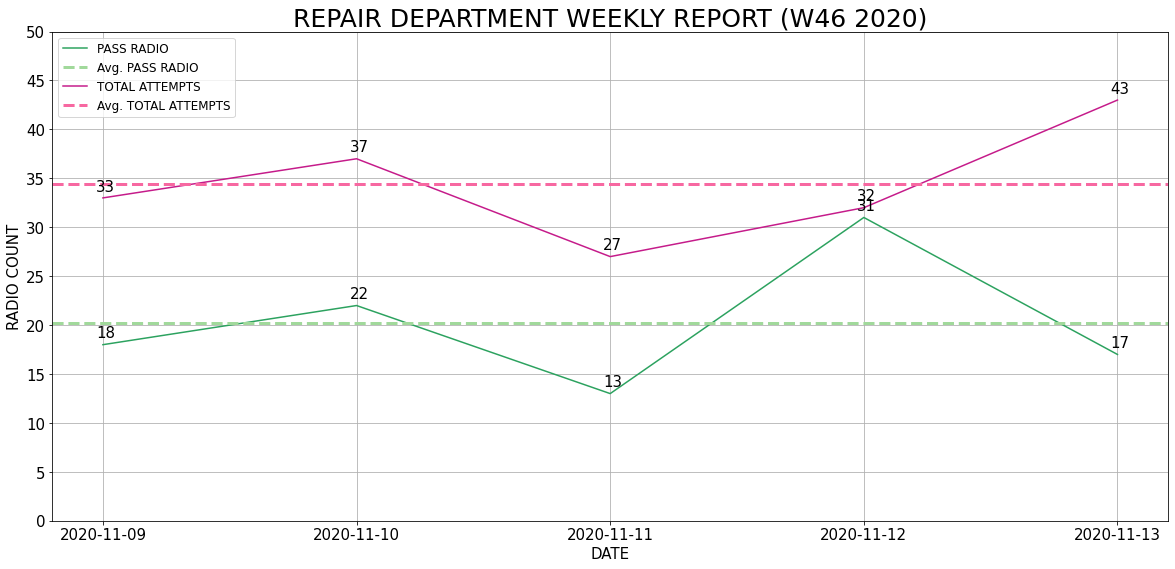

<Figure size 1440x648 with 0 Axes>

In [167]:
radios_type=["KRK10101/11", "KRK10101/21"]
radios=["RF", "DIG."]

tmp = (merged[merged['ProductNo'].isin(radios_type)]
            .groupby(['DATE','ProductNo'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','RBU 6701_SN']]
            .rename(columns={'RBU 6701_SN': "Count"})
       
      )

tmp1 = (merged[merged['FAIL Category'].isin(radios)]
            .groupby(['DATE','RBU 6701_SN'])
            .count()
            .reset_index()
            .groupby('DATE')
            .sum()
            .reset_index()
            .loc[:, ['DATE','FAIL Category']]
            .rename(columns={'FAIL Category': "Count"})
       
      )


tmp['DATE'] = pd.to_datetime(tmp['DATE'], dayfirst = True)

tmp = tmp.sort_values(by='DATE',ascending=True).reset_index()

tmp['DATE'] = tmp['DATE'].astype(str)


tmp1['DATE'] = pd.to_datetime(tmp1['DATE'], dayfirst = True)

tmp1 = tmp1.sort_values(by='DATE',ascending=True).reset_index()

tmp1['DATE'] = tmp1['DATE'].astype(str)


average_tmp = np.average(tmp['Count'])

average_tmp1 = np.average(tmp1['Count'])




from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 15})



fig = plt.figure().gca()
fig.yaxis.set_major_locator(MaxNLocator(integer=True))

x = np.array(tmp['DATE'])
y = np.array(tmp['Count'])

y1 = np.array(tmp1['Count'])

values = list(tmp1['Count'])
values1 = list(tmp['Count'])

plt.xlabel('DATE')
plt.ylabel('RADIO COUNT')


plt.title('REPAIR DEPARTMENT WEEKLY REPORT (W46 2020)', fontsize=25)

plt.plot(x, y, color='#2ca25f', linestyle='solid', label='PASS RADIO')
plt.axhline(average_tmp, color="#a1d99b", linestyle='dashed', linewidth=3)

plt.plot(x, y1, color='#c51b8a', linestyle='solid', label='TOTAL ATTEMPTS')

plt.axhline(average_tmp1, color="#f768a1", linestyle='dashed', linewidth=3)



for i, v in enumerate(values):
    plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')
    
for i, v in enumerate(values1):
    plt.annotate(str(v), xy=(i,v), xytext=(-7,7), textcoords='offset points')
    
plt.ylim(0, 50)

plt.legend(['PASS RADIO', 'Avg. PASS RADIO','TOTAL ATTEMPTS', 'Avg. TOTAL ATTEMPTS'], fontsize=12)

plt.grid()
plt.show()

plt.savefig("Repair_department_weekly_report_W46_linegraph.png")

# plt.annotate(
#         label,                      # Use `label` as label
#         (x_value, y_value),         # Place label at end of the bar
#         xytext=(space, 0),          # Horizontally shift label by `space`
#         textcoords="offset points", # Interpret `xytext` as offset in points
#         va='center',                # Vertically center label
#         ha=ha) 

#plt.rcParams["figure.figsize"] = [20,9]




# p = gg.ggplot(tmp, gg.aes(x='DATE', y='Count')) + \
#     gg.geom_line(color='black', size=4, linetype='solid') + \
#     gg.theme_classic() + \
#     gg.theme(axis_text_x = gg.element_text(color="black", size=8, angle=45, hjust=-5)) + \
#     gg.labs(title= 'REPAIR DEPARTMENT WEEKLY REPORT',
#             x="DATE",
#             y="RADIO COUNT"
#            ) 

# p   
    
# # #g = p + gg.theme(figure_size=(11, 6), axis_text_x=gg.element_text(rotation=45)


array(['2020-11-09', '2020-11-10', '2020-11-11', '2020-11-12',
       '2020-11-13'], dtype=object)

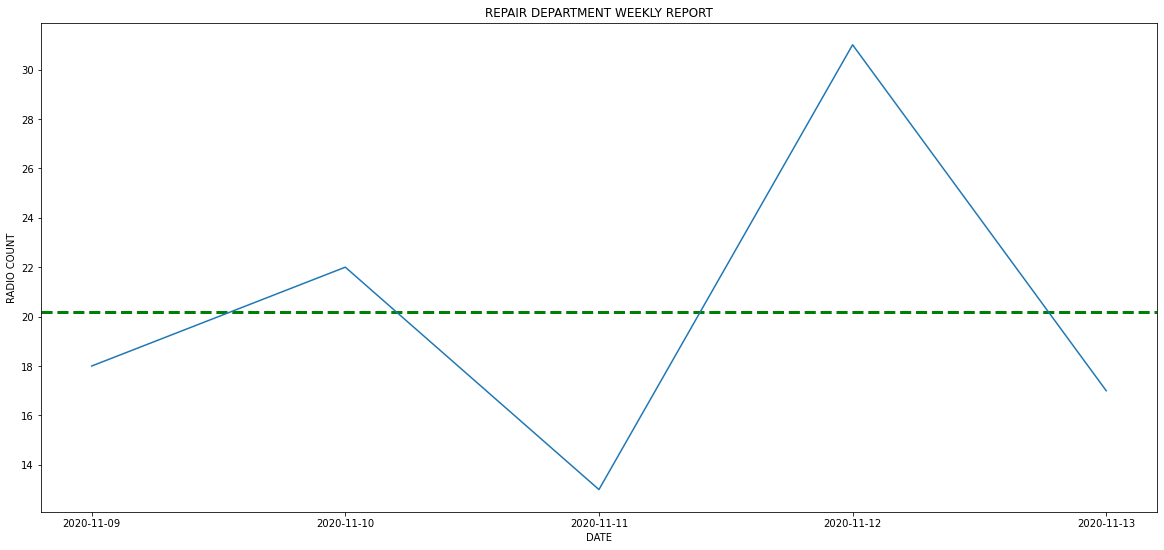

In [33]:
tmp1 = (merged[merged['ProductNo'].isin(radios)]
            .groupby(['DATE','ProductNo'])
            .count()
            .reset_index()
       
      )
tmp1


,DATE,ProductNo,RBU 6701_SN,FAIL Category,Fail Group,TRSH NAME,STATUS,Notes,REPAIR Person,REPAIR NOTES,PRE-TRSH Person,Unnamed: 10
0,"Friday, November 13, 2020",KRK10101/11,3,3,3,3,3,1,0,0,1,1
1,"Friday, November 13, 2020",KRK10101/21,14,14,14,12,14,3,8,8,14,4
2,"Monday, November 9, 2020",KRK10101/11,18,18,18,18,18,13,7,7,10,2
3,"Thursday, November 12, 2020",KRK10101/11,10,9,10,10,10,7,4,4,4,0
4,"Thursday, November 12, 2020",KRK10101/21,21,20,21,5,21,5,2,2,20,0
5,"Tuesday, November 10, 2020",KRK10101/11,22,21,22,20,22,12,9,7,17,3
6,"Wednesday, November 11, 2020",KRK10101/11,13,13,13,12,13,8,3,2,10,1


## Plotting for Trouble shooters

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Desktop/khawar/Repair Department Performance/W46_2020/figures/Trouble_shooters_performance.png


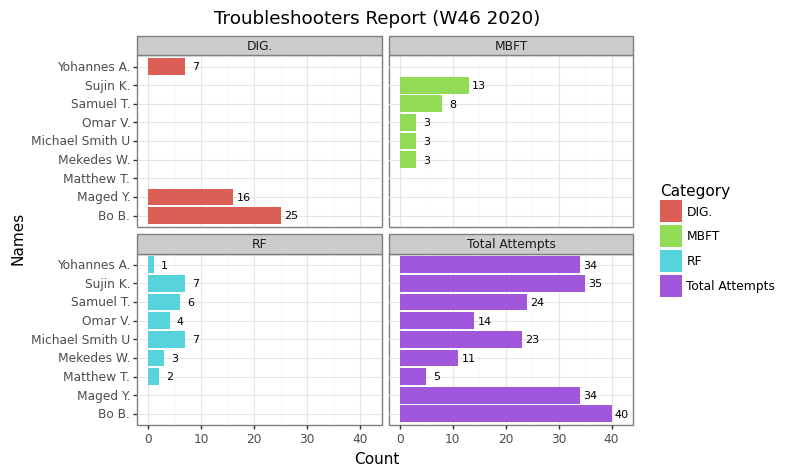

<ggplot: (7032479273)>

In [824]:
cat_condition=["DIG.", "RF", "MBFT", "I.C.O. (TRSH)"]

merged_df = (merged[merged['FAIL Category'].isin(cat_condition)]
            .groupby(['TRSH NAME','ProductNo', "FAIL Category"])
            .count()
            .reset_index()
            .groupby(['TRSH NAME', "FAIL Category"])
            .sum()
            .reset_index()
            .loc[:, ['TRSH NAME','FAIL Category', 'DATE']]
            .rename(columns={'TRSH NAME': 'Names',
                             'DATE': "Count",
                             'FAIL Category': "Category"
                            })
                 
            )

total = (merged.groupby('TRSH NAME').count()
        .reset_index()
        .loc[:, ['TRSH NAME','DATE']]
        .rename(columns={'TRSH NAME': 'Names',
                         'DATE': "Count",
                        })
        )



total['Category'] = 'Total Attempts'

total = total.loc[:, ['Names', 'Category', 'Count']]
fn = merged_df.append(total)



p = gg.ggplot(fn, gg.aes(x='Names', y='Count',fill="Category")) + \
    gg.geom_col(stat="identity") + \
    gg.theme_bw() + \
    gg.coord_flip() + \
    gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                 size=8, nudge_x=0, nudge_y=2, show_legend=True) + \
    gg.labs(title= 'Troubleshooters Report (W46 2020)')

   
    
p = p + gg.facet_wrap('~ Category', nrow=2)



# #print(p + facet_wrap('~ mask', nrow=2, scales="free_y"))
    

    

gg.ggsave(filename='Trouble_shooters_performance.png', plot = p, path = outpath)


p



## KPI

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Desktop/khawar/Repair Department Performance/W46_2020/figures/Trouble_shooters_KPI.png


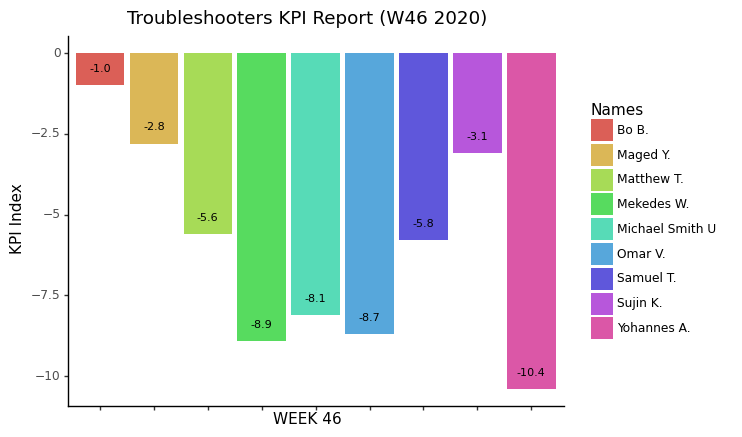

<ggplot: (7030251093)>

In [823]:
min_threshold_radio=30
target_radio=35
min_threshold_board=10
target_board=12



def repair_dept_kpi(x):
    
    if (x['Category'] == 'RF') | (x['Category'] == 'DIG.'):
        return "Radio"
    
    elif (x['Category'] == 'MBFT') | (x['Category'] == "I.C.O.(TRSH)"):
        return "Board"
    

    
def KPI_radio(x):
    
    if x['Category'] == "Radio":

        k = (x['Count'] - min_threshold_radio) / (target_radio - min_threshold_radio)
    
        return k


def KPI_board(x):
    
    if x['Category'] == "Board":

        k = (x['Count'] - min_threshold_board) / (target_board - min_threshold_board)
    
        return k


    
        
kpi = merged_df.copy()


kpi['Category'] = kpi.apply(repair_dept_kpi, axis=1)

kpi['KPI_Radio'] = kpi.apply(KPI_radio, axis=1)

kpi['KPI_board'] = kpi.apply(KPI_board, axis=1)

kpi = (kpi.groupby("Names")
       .sum()
       .reset_index()
       .assign(Total_Kpi = lambda x: np.round(x['KPI_Radio'] + x['KPI_board'], 1))
      )



g = gg.ggplot(kpi, gg.aes(x='Names', y='Total_Kpi',fill="Names")) + \
    gg.geom_col(stat="identity") + \
    gg.theme_classic() + \
    gg.geom_text(gg.aes(y = "Total_Kpi",label = "Total_Kpi"),  
                 size=8, nudge_x=0, nudge_y=0.5, show_legend=True) + \
    gg.labs(title= 'Troubleshooters KPI Report excluded_trb',
            x="WEEK 46",
            y="KPI Index"
           ) + \
    gg.theme(axis_text_x=gg.element_blank())
#     gg.theme(axis_text_x = gg.element_text(color="black", size=8,
#                                                          angle=45, hjust=-5),
#                            axis_text_y = gg.element_text(color="black", size=10))


 


 
#g = p + gg.themes(axis_text_x=element_text(rotation=90, hjust=1))
    
#g = p + gg.facet_wrap('~ Category', nrow=2)

#+ geom_hline(aes(yintercept = c['mean'].mean(), color=["Overall mean"]))

# #print(p + facet_wrap('~ mask', nrow=2, scales="free_y"))
    

    

gg.ggsave(filename='Trouble_shooters_KPI.png', plot = g, path = outpath)


g

In [827]:
merged['FAIL Category'].unique()

array(['DIG.', 'MBFT', 'RF', 'Mech.', 'Validation Radio Test', nan, 'MVI',
       'SMA Repair', 'Re-work Order'], dtype=object)

### Plotting for Pre-trouble shooters

/Users/habbasi/plotnine/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/habbasi/plotnine/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/habbasi/Desktop/khawar/Repair Department Performance/W46_2020/figures/Pretrouble_shooters_performance.png


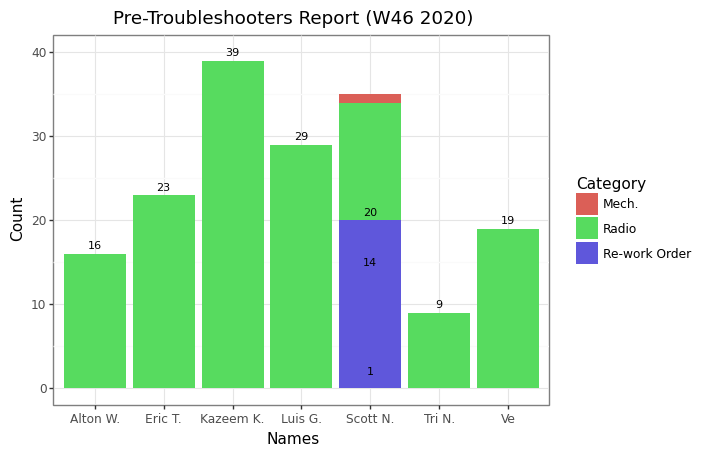

<ggplot: (7033897769)>

In [847]:
excluded_trb=['Phat N.', 'Tuan L.']


merged_trb = merged.copy()

trb = ['DIG.', 'RF','Mech.', 'ALT2', 'Validation Radio Test', 'Re-work Order']

merged_trb = merged_trb.loc[merged_trb['FAIL Category'].isin(trb)]

merged_trb['FAIL Category'] = merged_trb.apply(repair_dept_namechange, axis=1)



merged_trb = (merged_trb.groupby(['PRE-TRSH Person',"FAIL Category"])
              .count()
              .reset_index()
              .loc[:, ['PRE-TRSH Person','FAIL Category', 'DATE']]
              .rename(columns={'PRE-TRSH Person': 'Names',
                               'FAIL Category':"Category",
                               'DATE': "Count"})
 
             )


merged_trb = merged_trb[~merged_trb['Names'].isin(excluded_trb)]

pre = gg.ggplot(merged_trb, gg.aes(x='Names', y='Count', fill="Category")) + \
    gg.geom_bar(stat="identity") + \
    gg.theme_bw() + \
    gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                 size=8, nudge_x=0, nudge_y=1, show_legend=False) + \
    gg.labs(title= 'Pre-Troubleshooters Report (W46 2020)') 


    

    

gg.ggsave(filename='Pretrouble_shooters_performance.png', plot = pre, path = outpath)


pre

In [848]:
## categories for pre-troubleshooters
# trb = ['DIG.', 'RF','Mech.', 'ALT2', 'Validation Radio Test']

# #excluded_trb=['Tuan L.', 'Phat N.']


# excluded_trb=['Tuan', 'Phat']


# merged_trb = merged_trb.loc[merged_trb['FAIL Category'].isin(trb)]

#merged_trb['FAIL Category'] = merged_trb.apply(repair_dept_namechange, axis=1)



#               .groupby(['PRE-TRSH Person',"FAIL Category"])
#               .count()
#               .reset_index()
#               .loc[:, ['PRE-TRSH Person','FAIL Category', 'DATE']]
#               .rename(columns={'PRE-TRSH Person': 'Names',
#                                'FAIL Category':"Category",
#                                'DATE': "Count"})
 
#              )


# merged_trb = merged_trb[~merged_trb['Names'].isin(excluded_trb)]


## MVI Weekly report

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

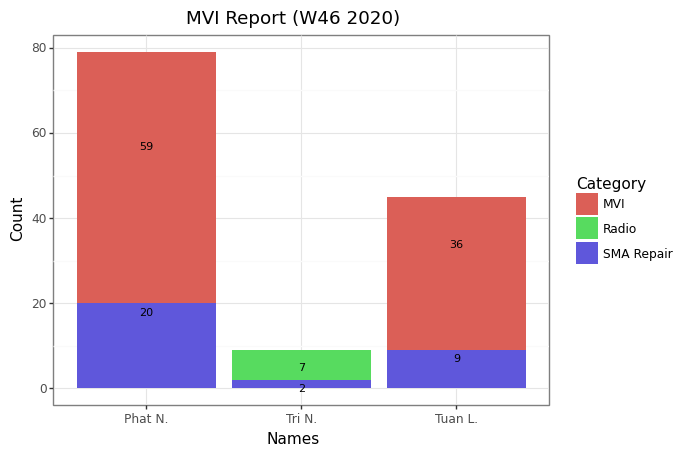

<ggplot: (7043357949)>

In [858]:
mvi_trb=['Tri N.', 'Tuan L.', 'Phat N.']


mvi = merged[merged['PRE-TRSH Person'].isin(mvi_trb)]


mvi['FAIL Category'] = mvi.apply(repair_dept_namechange, axis=1)
      



# change = mvi.sample(round(0.2 * len(mvi))).index


# mvi.loc[change,'FAIL Category'] = 'SMA Repair'




mvi = (mvi.groupby(['PRE-TRSH Person',"FAIL Category"])
       .count()
       .reset_index()
       .loc[:, ['PRE-TRSH Person','FAIL Category', 'DATE']]
       .rename(columns={'PRE-TRSH Person': 'Names',
                               'FAIL Category':"Category",
                               'DATE': "Count"})
 
             )


mvi_plot = gg.ggplot(mvi, gg.aes(x='Names', y='Count', fill="Category")) + \
    gg.geom_bar(stat="identity") + \
    gg.theme_bw() + \
    gg.geom_text(gg.aes(y = "Count",label = "Count"),  
                 size=8, nudge_x=0, nudge_y=-2, show_legend=True) + \
    gg.labs(title= 'MVI Report (W46 2020)') 


    

    

gg.ggsave(filename='MVI_performance_modified.png', plot = mvi_plot, path = outpath)



mvi_plot

In [860]:
merged['FAIL Category'].unique()

array(['DIG.', 'MBFT', 'RF', 'Mech.', 'Validation Radio Test', nan, 'MVI',
       'SMA Repair', 'Re-work Order'], dtype=object)



## Soldering Weekly report


In [900]:
def repairsoldering_dept_namechange(x):
    
    if (x['FAIL Category'] == 'RF') | (x['FAIL Category'] == 'DIG.'):
        return "Radio"

    elif (x['FAIL Category'] == 'SMA Repair'):
        return "SMA Repair"
    
    elif (x['FAIL Category'] == 'I.C.O. (TRSH)'):
        return "I.C.O. (TRSH)"
      
    elif (x['FAIL Category'] ==  "MBFT"):
        return "MBFT"



repair = merged[merged['REPAIR Person'].isin(REPAIR_NAME)]

repair['FAIL Category'] = repair.apply(repairsoldering_dept_namechange, axis=1)


repair = (repair.groupby(['REPAIR Person','REPAIR NOTES', 'FAIL Category'])
          .count()
          .reset_index()
#           .loc[:, ['REPAIR Person','REPAIR NOTES', 'FAIL Category', 'DATE']]
#           .rename(columns={'REPAIR Person': 'Names',
#                                'FAIL Category':"Category",
#                                'DATE': "Count"})
         )
          
repair
# soldering = gg.ggplot(repair, gg.aes(x='Names', y='Count', fill="Category")) + \
#     gg.geom_bar(stat="identity") + \
#     gg.theme_bw() + \    
#     gg.geom_text(gg.aes(y = "Count",label = "Count"),  
#                  size=8, nudge_x=0, nudge_y=-1, show_legend=True) + \
#     gg.labs(title= 'Soldering Report (W46 2020)') 


    

    

# gg.ggsave(filename='soldering_performance.png', plot = soldering, path = outpath)


# soldering

/Users/habbasi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,REPAIR Person,REPAIR NOTES,FAIL Category,DATE,RBU 6701_SN,Fail Group,TRSH NAME,STATUS,Notes,PRE-TRSH Person,Unnamed: 10,ProductNo
0,Daniel S.,1 x IC,MBFT,4,4,3,4,4,3,0,0,3
1,Daniel S.,1 x IC,Radio,4,4,4,4,4,1,2,1,3
2,Daniel S.,1 x IC,SMA Repair,1,1,1,0,1,0,1,0,1
3,Daniel S.,2 x IC,Radio,2,2,2,2,2,2,1,0,1
4,Daniel S.,Connector,Radio,2,2,2,2,2,2,0,0,1
5,Daniel S.,Connector,SMA Repair,1,1,1,0,1,0,1,1,1
6,Daniel S.,Passive Comp.,SMA Repair,3,3,1,0,2,1,2,2,2
7,Khaliah T.,1 x IC,MBFT,2,2,2,2,2,2,0,0,0
8,Khaliah T.,1 x IC,Radio,3,3,3,3,3,2,1,0,1
9,Khaliah T.,2 x IC,MBFT,2,2,2,2,2,2,0,0,1


In [880]:
repair

,Names,REPAIR NOTES,Category,Count
0,Daniel S.,1 x IC,MBFT,4
1,Daniel S.,1 x IC,Radio,4
2,Daniel S.,1 x IC,SMA Repair,1
3,Daniel S.,2 x IC,Radio,2
4,Daniel S.,Connector,Radio,2
5,Daniel S.,Connector,SMA Repair,1
6,Daniel S.,Passive Comp.,SMA Repair,3
7,Khaliah T.,1 x IC,MBFT,2
8,Khaliah T.,1 x IC,Radio,3
9,Khaliah T.,2 x IC,MBFT,2


## Repair department weekly report

In [886]:
tmp = (merged_df.groupby('Category')
.sum()
.reset_index()
      )

trb = ['Mech.', 'ALT2', 'Re-work Order']
tmp1 = merged_trb.query("Category in @trb").drop(columns='Names')


tmp2 = (repair.query("Category == 'SMA Repair'")
.groupby("Category")
.sum()
.reset_index()
       )

tmp3 = pd.concat([tmp, tmp1, tmp2], ignore_index=True)

# tmp2 = (tmp.append(tmp1)
# .reset_index()
# .drop(columns='index')
# )
tmp3

,Category,Count
0,DIG.,48
1,MBFT,30
2,RF,30
3,Mech.,1
4,Re-work Order,20
5,SMA Repair,6


ValueError: Unrecognized string   to axis; try on or off

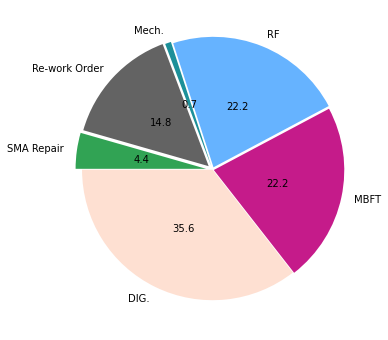

In [895]:
import matplotlib.pyplot as plt

labels = tmp3['Category'].unique()
l = labels.shape[0]
values = tmp3['Count'].values
e = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
c = ['#fee0d2', '#c51b8a','#66b3ff','#1c9099','#636363', '#31a354']
explode = e[:l]
colors = c[:l]


fig, ax = plt.subplots(figsize=(15, 6))
ax.pie(values,labels=labels, colors = colors, explode = explode, autopct='%1.1f',
        shadow=False, startangle=180, pctdistance=0.5)
# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis(' ')  
plt.tight_layout()
plt.title('Repair Department Weekly report (W46 2020)')
#plt.savefig(os.path.join(figpath, 'piechart {0}.png'.format(i)), bbox_inches = 'tight')



In [ ]:
plt.rcParams['font.size'] = 15


    
comp = final.loc[final['mask2'] == str(p)]
labels = ['Not Classified', 'Myeloid Cells']
    lab = comp['Classification_1'].unique()
    l = lab.shape[0]
    values = comp['Classification_1'].value_counts(dropna=False)
    c = ['#fee0d2', '#c51b8a','#66b3ff','#1c9099','#636363', '#31a354']
    e = [0, 0.1, 0.4, 0.6, 0.8, 1]
    explode = e[:l]
    colors = c[:l]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.pie(values,labels=labels, colors = colors, explode = explode, autopct='%1.1f',
            shadow=False, startangle=180, pctdistance=0.5)
# Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.tight_layout()
    plt.title(str(p))
    plt.savefig(os.path.join(figpath, 'piechart {0}.png'.format(i)), bbox_inches = 'tight')

    